In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import string
import pickle
import xlrd

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

# from sklearn.svm import LinearSVC
# from sklearn.ensemble import RandomForestClassifier


In [4]:
data = pd.read_excel('/content/drive/My Drive/dataset/dataset.xlsx', engine='openpyxl')

In [5]:
print("Columns in the original dataset:\n")
print(data.columns)

Columns in the original dataset:

Index(['URL', 'Text', 'Sentiment'], dtype='object')


In [6]:
data.head()

,URL,Text,Sentiment
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS


In [7]:
def map_sentiment(sentiment):
    if sentiment == 'NEG':
        return -1
    else:
        return 1

Number of rows per star rating:
NEG    1000
POS     999
Name: Sentiment, dtype: int64


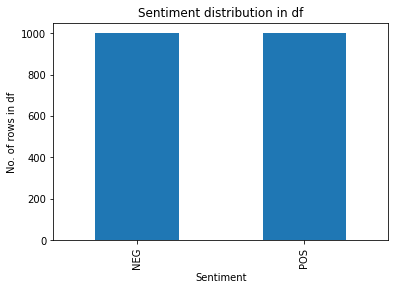

In [8]:
print("Number of rows per star rating:")
print(data['Sentiment'].value_counts())

# Plotting the sentiment distribution
plt.figure()
pd.value_counts(data['Sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [11]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
# Tokenize the text column to get the new column 'tokenized_text'
data['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in data['Text']] 
print(data['tokenized_text'].head(10))

0    [girlfight, follows, project, dwelling, new, y...
1    [hollywood, north, is, an, euphemism, from, th...
2    [that, show, is, definitely, the, funniest, sh...
3    [minutes, of, pure, holiday, terror, okay, so,...
4    [series, of, random, seemingly, insignificant,...
5    [very, good, adaptation, of, the, novel, by, a...
6    [ah, moonwalker, huge, michael, jackson, fan, ...
7    [although, the, beginning, of, the, movie, in,...
8    [as, many, reviewers, here, have, noted, the, ...
9    [bear, in, mind, any, film, let, alone, docume...
Name: tokenized_text, dtype: object


In [24]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
data['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in data['tokenized_text'] ]
data['stemmed_tokens'].head(10)

0    [girlfight, follow, project, dwell, new, york,...
1    [hollywood, north, is, an, euphem, from, the, ...
2    [that, show, is, definit, the, funniest, show,...
3    [minut, of, pure, holidai, terror, okai, so, i...
4    [seri, of, random, seemingli, insignific, thef...
5    [veri, good, adapt, of, the, novel, by, amrita...
6    [ah, moonwalk, huge, michael, jackson, fan, gr...
7    [although, the, begin, of, the, movi, in, new,...
8    [as, mani, review, here, have, note, the, film...
9    [bear, in, mind, ani, film, let, alon, documen...
Name: stemmed_tokens, dtype: object

In [25]:
data.head()

,URL,Text,Sentiment,tokenized_text,stemmed_tokens
0,http://www.imdb.com/title/tt0210075/usercomments,Girlfight follows a project dwelling New York ...,POS,"[girlfight, follows, project, dwelling, new, y...","[girlfight, follow, project, dwell, new, york,..."
1,http://www.imdb.com/title/tt0337640/usercomments,Hollywood North is an euphemism from the movie...,POS,"[hollywood, north, is, an, euphemism, from, th...","[hollywood, north, is, an, euphem, from, the, ..."
2,http://www.imdb.com/title/tt0303549/usercomments,That '70s Show is definitely the funniest show...,POS,"[that, show, is, definitely, the, funniest, sh...","[that, show, is, definit, the, funniest, show,..."
3,http://www.imdb.com/title/tt0716825/usercomments,"9/10- 30 minutes of pure holiday terror. Okay,...",POS,"[minutes, of, pure, holiday, terror, okay, so,...","[minut, of, pure, holidai, terror, okai, so, i..."
4,http://www.imdb.com/title/tt0182225/usercomments,"A series of random, seemingly insignificant th...",POS,"[series, of, random, seemingly, insignificant,...","[seri, of, random, seemingli, insignific, thef..."


In [28]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(data, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(data[['Text', 'stemmed_tokens']], 
                                                        data['Sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test


In [29]:
# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(data)

Value counts for Train sentiments
POS    710
NEG    689
Name: Sentiment, dtype: int64
Value counts for Test sentiments
NEG    311
POS    289
Name: Sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0    785  ...  [such, film, of, beauti, that, it, hard, to, d...
1   1885  ...  [thi, can, be, mandi, schaffer, last, film, so...
2    723  ...  [final, movi, where, the, audienc, is, kept, g...
3   1114  ...  [remad, todai, thi, film, would, be, veri, cre...
4     60  ...  [thi, film, wa, the, first, british, teen, mov...

[5 rows x 3 columns]


In [30]:
X_train.head()

,index,Text,stemmed_tokens
0,785,Such a film of beauty that it's hard to descri...,"[such, film, of, beauti, that, it, hard, to, d..."
1,1885,This can't be Mandy Schaffer's last film. Some...,"[thi, can, be, mandi, schaffer, last, film, so..."
2,723,Finally a movie where the audience is kept gue...,"[final, movi, where, the, audienc, is, kept, g..."
3,1114,"Remade today, this film would be a very creepy...","[remad, todai, thi, film, would, be, veri, cre..."
4,60,This film was the first British teen movie to ...,"[thi, film, wa, the, first, british, teen, mov..."


In [31]:
Y_train.head()

,index,Sentiment
0,785,POS
1,1885,NEG
2,723,POS
3,1114,NEG
4,60,POS


In [32]:
from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1)
size = 1000
window = 3
min_count = 1
workers = 3
sg = 1

word2vec_model_file = 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(data['stemmed_tokens']).values
# Train the Word2Vec Model
w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 27.48318099975586


In [33]:
import numpy as np
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)
# Unique ID of the word
print("Index of the word 'action':")
print(sg_w2v_model.wv.vocab["action"].index)
# Total number of the words 
print(len(sg_w2v_model.wv.vocab))
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(sg_w2v_model['action']))
# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
print(np.mean([sg_w2v_model[token] for token in data['stemmed_tokens'][0]], axis=0))

Index of the word 'action':
210
17709
Length of the vector generated for a word
1000
Print the length after taking average of all word vectors in a sentence:
[-7.90733099e-02 -2.51973923e-02  3.17465961e-02  3.07416916e-02
 -2.92371260e-03  7.11078718e-02  3.75933312e-02  4.41663861e-02
  3.87230213e-03  6.36974573e-02  6.35054037e-02  1.04824184e-02
  5.22549637e-02 -4.25399505e-02  6.91185845e-03 -1.12851910e-01
  5.75181991e-02 -1.42624946e-02  2.21253876e-02  4.38813353e-03
  6.39852285e-02 -2.82416632e-03 -5.94052523e-02 -6.59090048e-03
  6.22790307e-03  7.46018812e-02  4.23639379e-02  8.99383351e-02
 -6.14188872e-02  7.29326606e-02 -3.15789022e-02  3.20443362e-02
 -6.97872639e-02 -4.26520891e-02 -3.56841460e-02 -1.11523420e-02
 -3.98193821e-02  7.07907453e-02  6.30190969e-02 -4.56122607e-02
  2.99607334e-03  1.17758084e-02 -7.85965100e-02 -7.54758269e-02
  3.25840004e-02 -4.96254042e-02  3.96726802e-02 -5.70196696e-02
  3.50952558e-02  5.24215139e-02 -7.91677460e-02  8.02943930e-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [34]:
# Store the vectors for train data in following file
word2vec_filename = 'train_review_word2vec.csv'
with open(word2vec_filename, 'w+') as word2vec_file:
    for index, row in X_train.iterrows():
        model_vector = (np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)).tolist()
        if index == 0:
            header = ",".join(str(ele) for ele in range(1000))
            word2vec_file.write(header)
            word2vec_file.write("\n")
        # Check if the line exists else it is vector of zeros
        if type(model_vector) is list:  
            line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
        else:
            line1 = ",".join([str(0) for i in range(1000)])
        word2vec_file.write(line1)
        word2vec_file.write('\n')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [36]:
import time
#Import the DecisionTreeeClassifier
from sklearn.tree import DecisionTreeClassifier
# Load from the filename
word2vec_df = pd.read_csv(word2vec_filename)
#Initialize the model
clf_decision_word2vec = DecisionTreeClassifier()

start_time = time.time()
# Fit the model
clf_decision_word2vec.fit(word2vec_df, Y_train['Sentiment'])
print("Time taken to fit the model with word2vec vectors: " + str(time.time() - start_time))

Time taken to fit the model with word2vec vectors: 1.6126441955566406


In [38]:
from sklearn.metrics import classification_report
test_features_word2vec = []
for index, row in X_test.iterrows():
    model_vector = np.mean([sg_w2v_model[token] for token in row['stemmed_tokens']], axis=0)
    if type(model_vector) is list:
        test_features_word2vec.append(model_vector)
    else:
        test_features_word2vec.append(np.array([0 for i in range(1000)]))
test_predictions_word2vec = clf_decision_word2vec.predict(test_features_word2vec)
print(classification_report(Y_test['Sentiment'],test_predictions_word2vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


              precision    recall  f1-score   support

         NEG       0.00      0.00      0.00       311
         POS       0.48      1.00      0.65       289

    accuracy                           0.48       600
   macro avg       0.24      0.50      0.33       600
weighted avg       0.23      0.48      0.31       600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
